In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
import torch

nltk.download('punkt')
nltk.download('stopwords')

file_path = '/content/Sherlock Holmes.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
with open(file_path, 'r', encoding='utf-8') as file:
  text = file.read()

print(text[:300])





                        THE ADVENTURES OF SHERLOCK HOLMES

                               Arthur Conan Doyle



                                Table of contents

               A Scandal in Bohemia
               The Red-Headed League
               A Case of Identity
               The Boscomb


**Upon a quick manual inspection of the corpus, it was observed that it contained twelve stories.**

In [3]:
story_titles = [title.lower() for title in [
    "A Scandal in Bohemia",
    "The Red-Headed League",
    "A Case of Identity",
    "The Boscombe Valley Mystery",
    "The Five Orange Pips",
    "The Man with the Twisted Lip",
    "The Adventure of the Blue Carbuncle",
    "The Adventure of the Speckled Band",
    "The Adventure of the Engineer's Thumb",
    "The Adventure of the Noble Bachelor",
    "The Adventure of the Beryl Coronet",
    "The Adventure of the Copper Beeches"
]]

# Split text into stories
stories = {}
current_story = None

# Skipping intro
for line in text[730:].split('\n'):
  if line.strip().lower() in story_titles:
    current_story = line.strip().lower()
    stories[current_story] = ""
  elif current_story:
    stories[current_story] += line + '\n'

story_titles = [t.lower() for t in [
    "A Scandal in Bohemia",
    "The Red-Headed League",
    "A Case of Identity",
    "The Boscombe Valley Mystery",
    "The Five Orange Pips",
    "The Man with the Twisted Lip",
    "The Adventure of the Blue Carbuncle",
    "The Adventure of the Speckled Band",
    "The Adventure of the Engineer's Thumb",
    "The Adventure of the Noble Bachelor",
    "The Adventure of the Beryl Coronet",
    "The Adventure of the Copper Beeches"
]]

# Split the text into stories
stories = {}
current_story = None
for line in text[730:].split('\n'):
    if line.strip().lower() in story_titles:
        current_story = line.strip().lower()

        stories[current_story] = ""
    elif current_story:
        stories[current_story] += line + '\n'


print(f"Total stories extracted: {len(stories)}")
first_title = list(stories.keys())[0]
print(f"First story: {first_title}, Content Preview: {stories[first_title][:1000]}")

Total stories extracted: 12
First story: a scandal in bohemia, Content Preview: 




                                Table of contents
                                     Chapter 1
                                     Chapter 2
                                     Chapter 3















          CHAPTER I



     To Sherlock Holmes she is always the woman. I have seldom heard him
     mention her under any other name. In his eyes she eclipses and
     predominates the whole of her sex. It was not that he felt any
     emotion akin to love for Irene Adler. All emotions, and that one
     particularly, were abhorrent to his cold, precise but admirably
     balanced mind. He was, I take it, the most perfect reasoning and
     observing machine that the world has seen, but as a lover he would
     have placed himself in a false position. He never spoke of the softer
     passions, save with a gibe and a sneer. They were admirable things
     for the observer--excellent for drawing the 

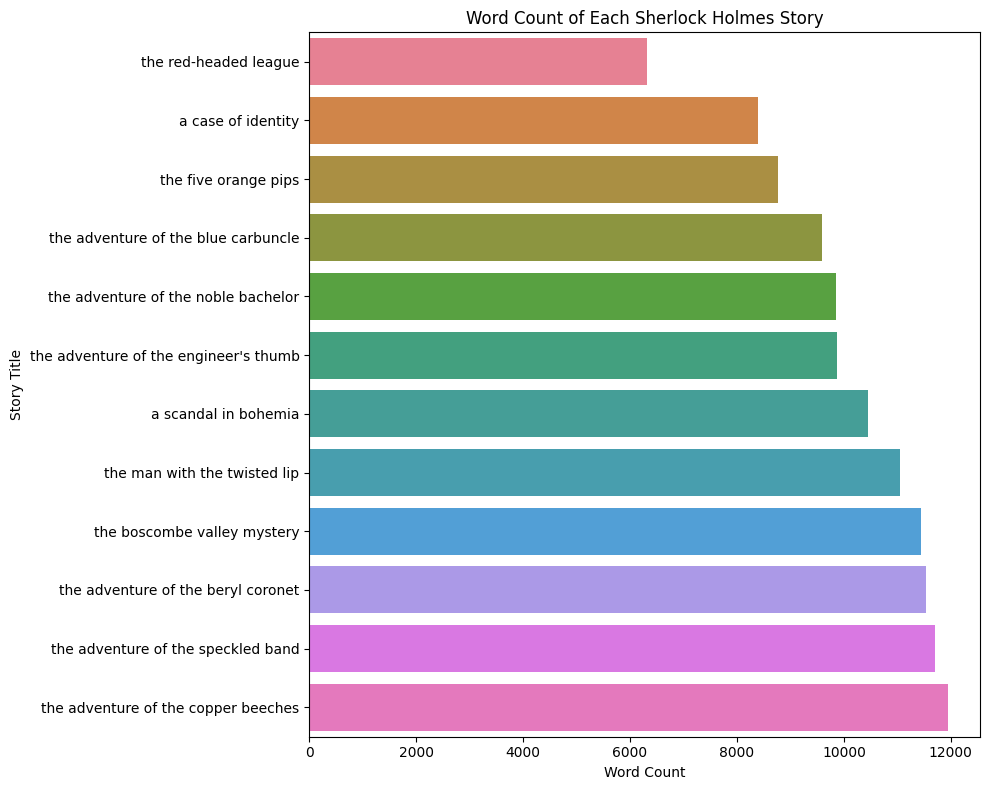

In [4]:
word_counts = {title: len(word_tokenize(text)) for title, text in stories.items()}

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Story Title', 'Word Count'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Word Count', y='Story Title', data=word_counts_df.sort_values('Word Count'), hue='Story Title')
plt.title('Word Count of Each Sherlock Holmes Story')
plt.xlabel('Word Count')
plt.ylabel('Story Title')
plt.tight_layout()

**The stories varied in length, with "The Red-Headed League" being the shortest at approximately 7,000 words, while "The Adventure of the Copper Beeches" is the longest, totaling around 12,000 words.**

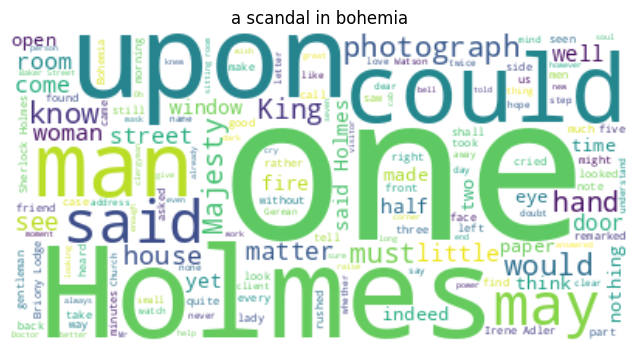

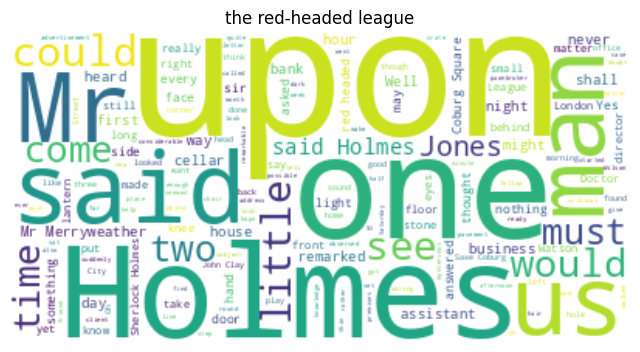

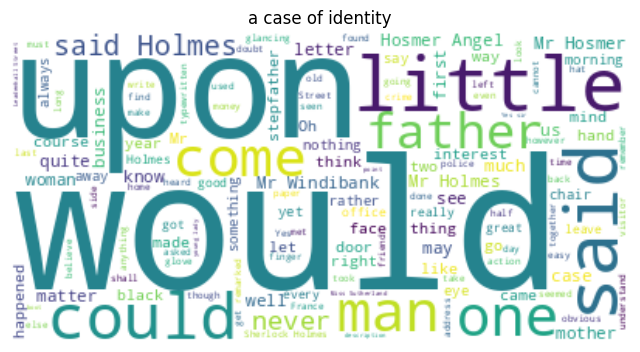

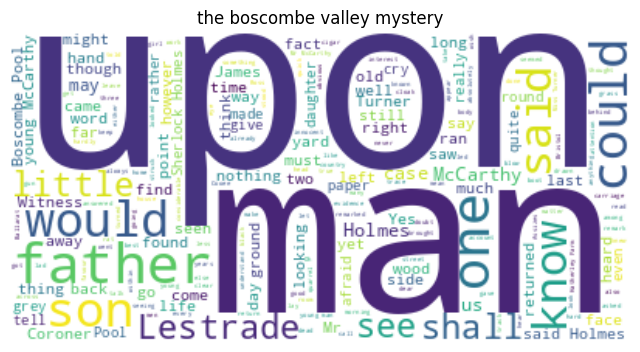

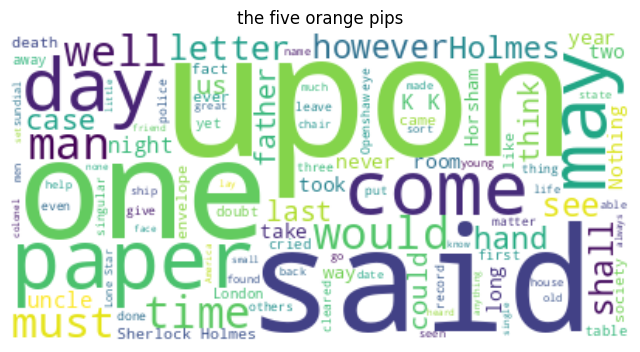

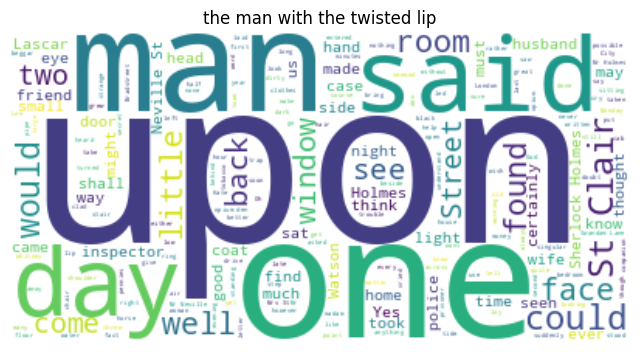

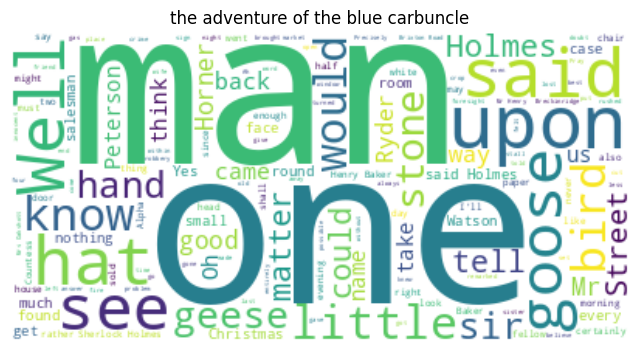

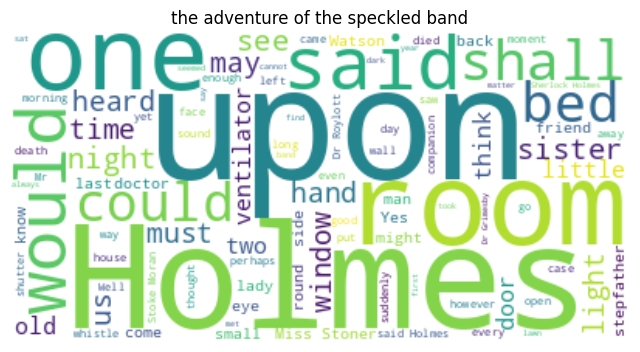

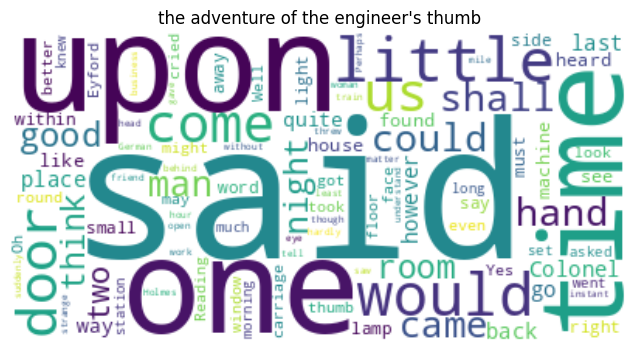

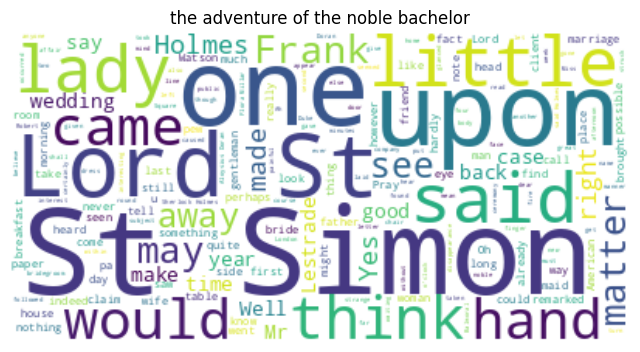

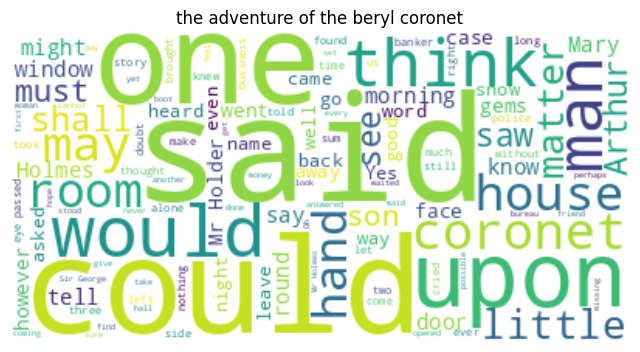

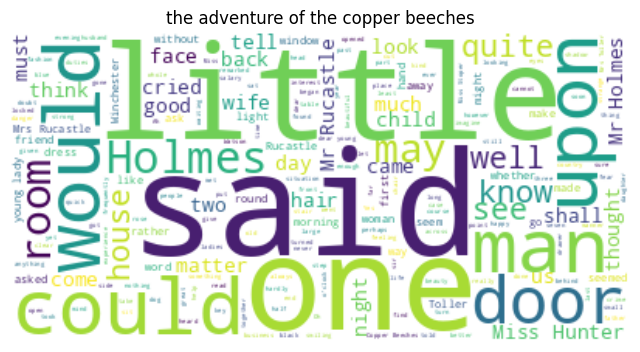

In [5]:
from wordcloud import WordCloud

# Create a function to generate a word cloud for each story
def generate_wordcloud(title, text):
    wordcloud = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate a word cloud for each story
for title, text in stories.items():
    generate_wordcloud(title, text)

The Type-Token Ratio (TTR) is a linguistic measure that assesses the diversity of vocabulary in a text by comparing the number of unique words (types) to the total number of words (tokens).

This ratio can vary between 0 and 1, with higher values indicating greater lexical variety. For example, if a text contains 400 unique words out of 1,000 total words, the TTR would be 40%.

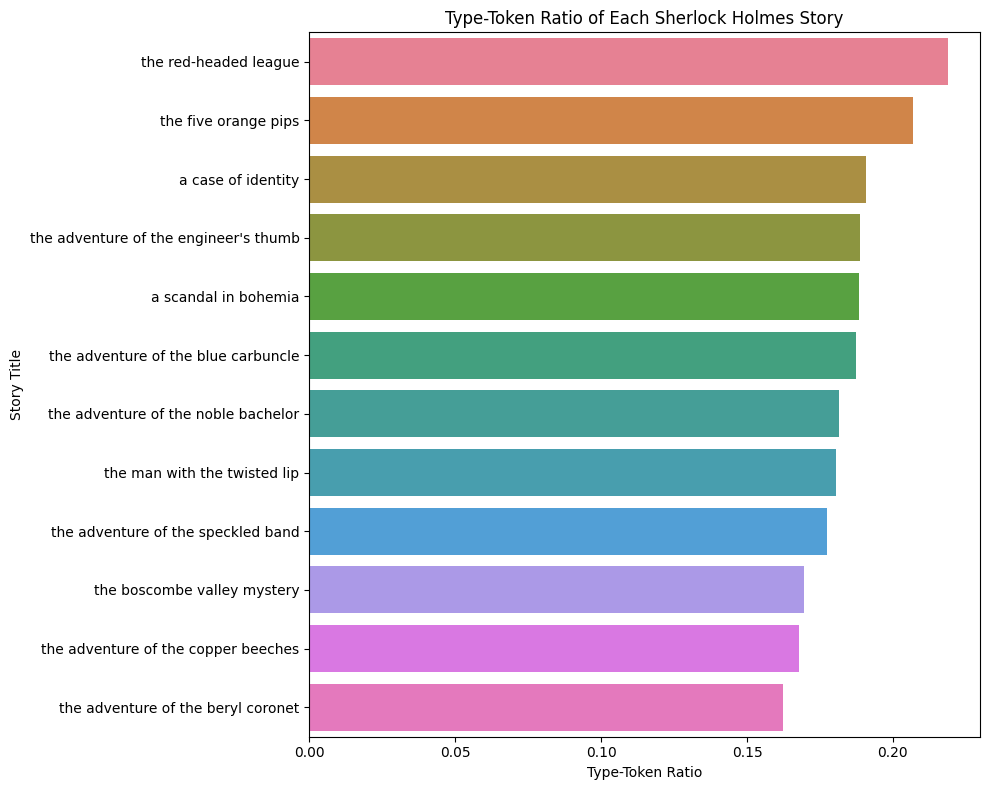

In [7]:
def calculate_ttr(text):
  tokens = word_tokenize(text.lower())
  types = set(tokens)
  return len(types) / len(tokens) if tokens else 0

ttr = {title: calculate_ttr(text) for title, text in stories.items()}

ttr_df = pd.DataFrame(list(ttr.items()), columns=['Story Title', 'Type-Token Ratio'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Type-Token Ratio', y='Story Title', data=ttr_df.sort_values('Type-Token Ratio', ascending=False), hue='Story Title')
plt.title('Type-Token Ratio of Each Sherlock Holmes Story')
plt.xlabel('Type-Token Ratio')
plt.ylabel('Story Title')
plt.tight_layout()

The corpus was divided to separate stories to feed into the network (which was done a few cells earlier, before the visualizations). Further, to be fed into a GPT2 based model for transfer learning (or fine tuning in this case), the stories need to be tokenized.

In [8]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenized_stories = []
for story in stories.values():
    # Encode the stories and add the special tokens
    tokenized_story = tokenizer.encode(story, add_special_tokens=True, max_length=1024, truncation=True)
    tokenized_stories.append(tokenized_story)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
from torch.utils.data import Dataset, DataLoader

class SherlockDataset(Dataset):
    def __init__(self, tokenized_stories):
        self.tokenized_stories = tokenized_stories

    def __len__(self):
        return len(self.tokenized_stories)

    def __getitem__(self, idx):
        return torch.tensor(self.tokenized_stories[idx])

dataset = SherlockDataset(tokenized_stories)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

### Model Building

Given the project's focus on text generation, it was decided to fine-tune GPT-2's weights to generate Sherlock Holmes style stories.

In [10]:


from transformers import GPT2LMHeadModel, AdamW
from torch.utils.data import random_split

model = GPT2LMHeadModel.from_pretrained('gpt2')

optimizer = AdamW(model.parameters(), lr=5e-5)

model.to(device)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
epochs = 100

model.train()
for epoch in (pbar:=tqdm(range(epochs))):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch.to(device)
        labels = batch.to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

  0%|          | 0/100 [00:08<?, ?it/s]


KeyboardInterrupt: 